In [2]:
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [43]:
data = pd.read_csv("./moneda.csv")

In [44]:
data = data.drop(['Fecha'], axis=1) 
data.dropna(inplace=True)
data.insert(loc=0, column='date', value=pd.to_datetime(data.index, dayfirst=True)) 
data['index'] = range(1, len(data) + 1)
data = data.set_index('index')

In [45]:
data.head()

,date,TCR1,Venta
index,,,
1,1970-01-01 00:00:00.000000000,6.14285,6.16625
2,1970-01-01 00:00:00.000000001,6.17433,6.19326
3,1970-01-01 00:00:00.000000002,6.17433,6.19326
4,1970-01-01 00:00:00.000000003,6.17433,6.19326
5,1970-01-01 00:00:00.000000004,6.16782,6.18593


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8397 entries, 1 to 8397
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8397 non-null   datetime64[ns]
 1   TCR1    8397 non-null   float64       
 2   Venta   8397 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 262.4 KB


<AxesSubplot:xlabel='TCR1', ylabel='Count'>

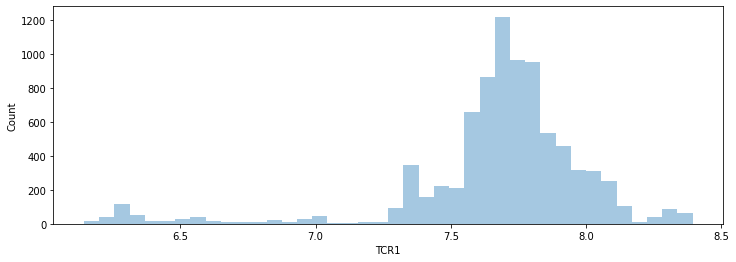

In [47]:
plt.figure(figsize=(12,4))
sns.histplot(data['TCR1'], kde=False, bins=40, alpha=0.4, linewidth= 0)

<AxesSubplot:xlabel='Venta', ylabel='Count'>

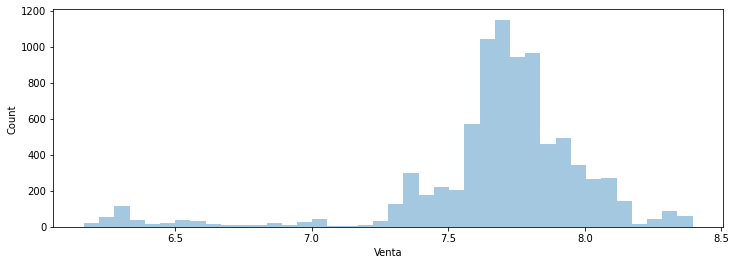

In [48]:
plt.figure(figsize=(12,4))
sns.histplot(data['Venta'], kde=False, bins=40, alpha=0.4, linewidth= 0)

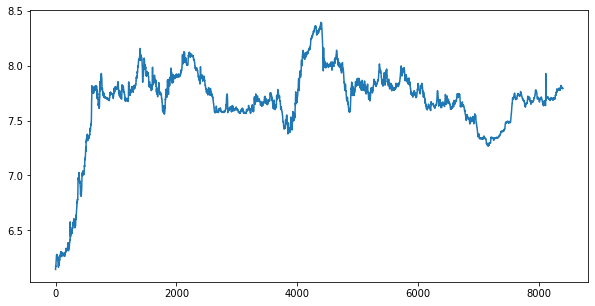

In [49]:
#ARREGLAR ESTA GRAFICA
plt.figure(figsize=(10, 5))
data['id']=list(range(0, len(data)))
# sns.scatterplot(x='id',y='Venta', data=data,)
plt.plot(data['id'], data['TCR1'], linestyle='-')
plt.show()

Modelos

In [50]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

ModuleNotFoundError: No module named 'ipywidgets'

In [60]:
def exponential(x, m, t, b):
    return m * np.exp(-t * x) + b

w = widgets.Dropdown(
    options=['Exponencial', 'Logaritmico', 'Polinomico','Promedios Moviles'],
    value='Exponencial',
    description='Modelo:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        if (w.value == 'Exponencial'):
            print('expo')
            #m * np.exp(-t * x) + b
            paramsExpModel, cv = curve_fit(
                    expModel, data.index, data['TCR1'], (2000, .01, 1))
            data['expModel'] = exponential(
                    data.index, *paramsExpModel)
        if (w.value == 'Logaritmico'):
            print('loga')
        if (w.value == 'Polinomico'):
            print('poli')
        if (w.value == 'Promedios Moviles'):
            print('movil')
            

w.observe(on_change)
display(w)



Dropdown(description='Modelo:', options=('Exponencial', 'Logaritmico', 'Polinomico', 'Promedios Moviles'), val…

changed to Polinomico
poli
changed to Exponencial
expo


NameError: name 'expModel' is not defined

In [ ]:
Suavizamiento Expoencial

In [55]:
# TODO: LA GRAFICA FUNCIONA PERO NO SE DEBE MOSTRAR ASI
def expModel(x, m, t, b):
    return m * np.exp(-t * x) + b

# data.head()
paramsExpModel, cv = curve_fit(expModel, data.index, data['TCR1'], (2000, .01, 1))

data['expModel'] = expModel(data.index, *paramsExpModel)

chart1 = px.line(data, x='date', y=['TCR1', 'expModel'])
chart1.show()

In [58]:
def logModel(x, a, b):
    return a*np.log(x) + b

paramsLogModel, cv = curve_fit(logModel, data.index, data['TCR1'])

data['logModel'] = logModel(data.index, *paramsLogModel)

chart2 = px.line(data, x='date', y=['TCR1', 'logModel'])

chart2.show()

In [ ]:
# NUESTRO SLIDER AQUI
# degree = st.slider('Grado:', 0, 30, 15)

# NUESTRO SLIDER AQUI
# parts = st.slider('Dividir el modelo en:', 1, 5, 1)

initial = 0
length = int(len(raw_data) / parts)

data['polModel'] = np.zeros(len(data))

for i in range(parts):

    if parts == i + 1:
        final = len(data)
    else:
        final = initial + length

    model3 = np.polyfit(data.index[initial:final], data['TCR1'][initial:final], degree)

    trendpoly3 = np.poly1d(model3)

    data['polModel'][initial:final] = trendpoly3(data.index[initial:final])

    initial = final

chart3 = px.line(data, x='date', y=['TCR1', 'polModel'])

In [ ]:
# SLIDER
degree = st.slider('Grado:', 0, 30, 15)
# SLIDER O LO QUE SEA 
window = st.slider('Ventana:', 1, 30, 10)

data['rolling'] = 0
data['rolling'] = data.rolling(window=window).mean()['TCR1']

model4 = np.polyfit(data.index[window:],data['rolling'][window:], degree)

trendpoly4 = np.poly1d(model4)

data['rollModel'] = trendpoly4(data.index)

chart4 = px.line(data, x='date', y=['TCR1', 'rollModel'])

In [ ]:
X = data['date']
y = data['TCR1']

train_size = st.slider(
    'Tamaño de los datos para entrenar:', 0.85, 0.98, 0.93)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, shuffle=False)

model = ExponentialSmoothing(y_train, seasonal=None, damped=True, trend='add')

model.index = X_train

fit = model.fit()

simulations = 100

for i in range(simulations):
    p = fit.simulate(len(y_test), error='add')
    if i == 0:
        preds = p
    else:
        preds = preds + p
pred = preds / simulations

forecast = fit.forecast(len(y_test))

chart5 = px.line(pd.DataFrame({
    'date': X,
    'TCR1': y,
    'fit': fit.fittedvalues,
    'predictions': pred,
    'forecast': forecast,
}), x='date', y=['TCR1', 'fit', 'predictions', 'forecast'])